In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

os.chdir('../')

from tgmm import GaussianMixture, GMMInitializer, dynamic_figsize, plot_gmm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
random_state = 42
np.random.seed(random_state)
torch.manual_seed(random_state)

if device == 'cuda':
    torch.cuda.manual_seed(random_state)
    print('CUDA version:', torch.version.cuda)
    print('Device:', torch.cuda.get_device_name(0))
else:
    print('Using CPU')

CUDA version: 12.4
Device: NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
n_samples = [800, 200, 1000, 1000]
centers = [np.array([0, 2]),
           np.array([2, -2]),
           np.array([0, 0]),
           np.array([2, 2])]
covs = [
    1.0 * np.eye(2),                    # spherical covariance
    0.5 * np.eye(2),                    # spherical covariance, fewer points
    np.array([[2, 0], [0, 0.5]]),       # diagonal covariance
    np.array([[0.2, 0.5], [0.5, 2]])    # full covariance
]

components = []
for n, center, cov in zip(n_samples, centers, covs):
    samples = np.dot(np.random.randn(n, 2), cov) + center
    components.append(samples)

X = np.vstack(components)
labels = np.concatenate([i * np.ones(n) for i, n in enumerate(n_samples)])
legend_labels = [f'Component {i+1}' for i in range(len(n_samples))]

n_features = X.shape[1]
n_components = len(n_samples)

In [4]:
# Convert to tensor (if needed for further processing)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

n_components = 4

# Initialize the GMM
gmm = GaussianMixture(
    n_components=n_components,
    covariance_type='full',
    tol=1e-6,
    reg_covar=1e-10,
    max_iter=1000,
    init_params='random',
    cov_init_method='eye',
    weights_init=None,
    means_init=None,
    covariances_init=None,
    n_init = 5,
    random_state=None,
    warm_start=False,
    verbose=False,
    verbose_interval=100,
    device='cpu',
)
# Fit the GMM
gmm.fit(X_tensor)

# Get predictions
y_pred = gmm.predict(X_tensor)

# Compute per-sample log-likelihoods
log_probs = gmm.score_samples(X_tensor)

# Get probabilities for each sample for each component
probs = gmm.predict_proba(X_tensor)
probs = probs.detach()

# Generate new samples
n_samples_to_generate = len(X)
gmm_samples, gmm_labels = gmm.sample(n_samples_to_generate)
gmm_samples = gmm_samples.detach().cpu().numpy()
gmm_labels = gmm_labels.detach().cpu().numpy()

# Compute probabilities for each generated sample
generated_probs = gmm.predict_proba(torch.tensor(gmm_samples, dtype=torch.float32).to(device))
generated_probs = generated_probs.detach().cpu().numpy()

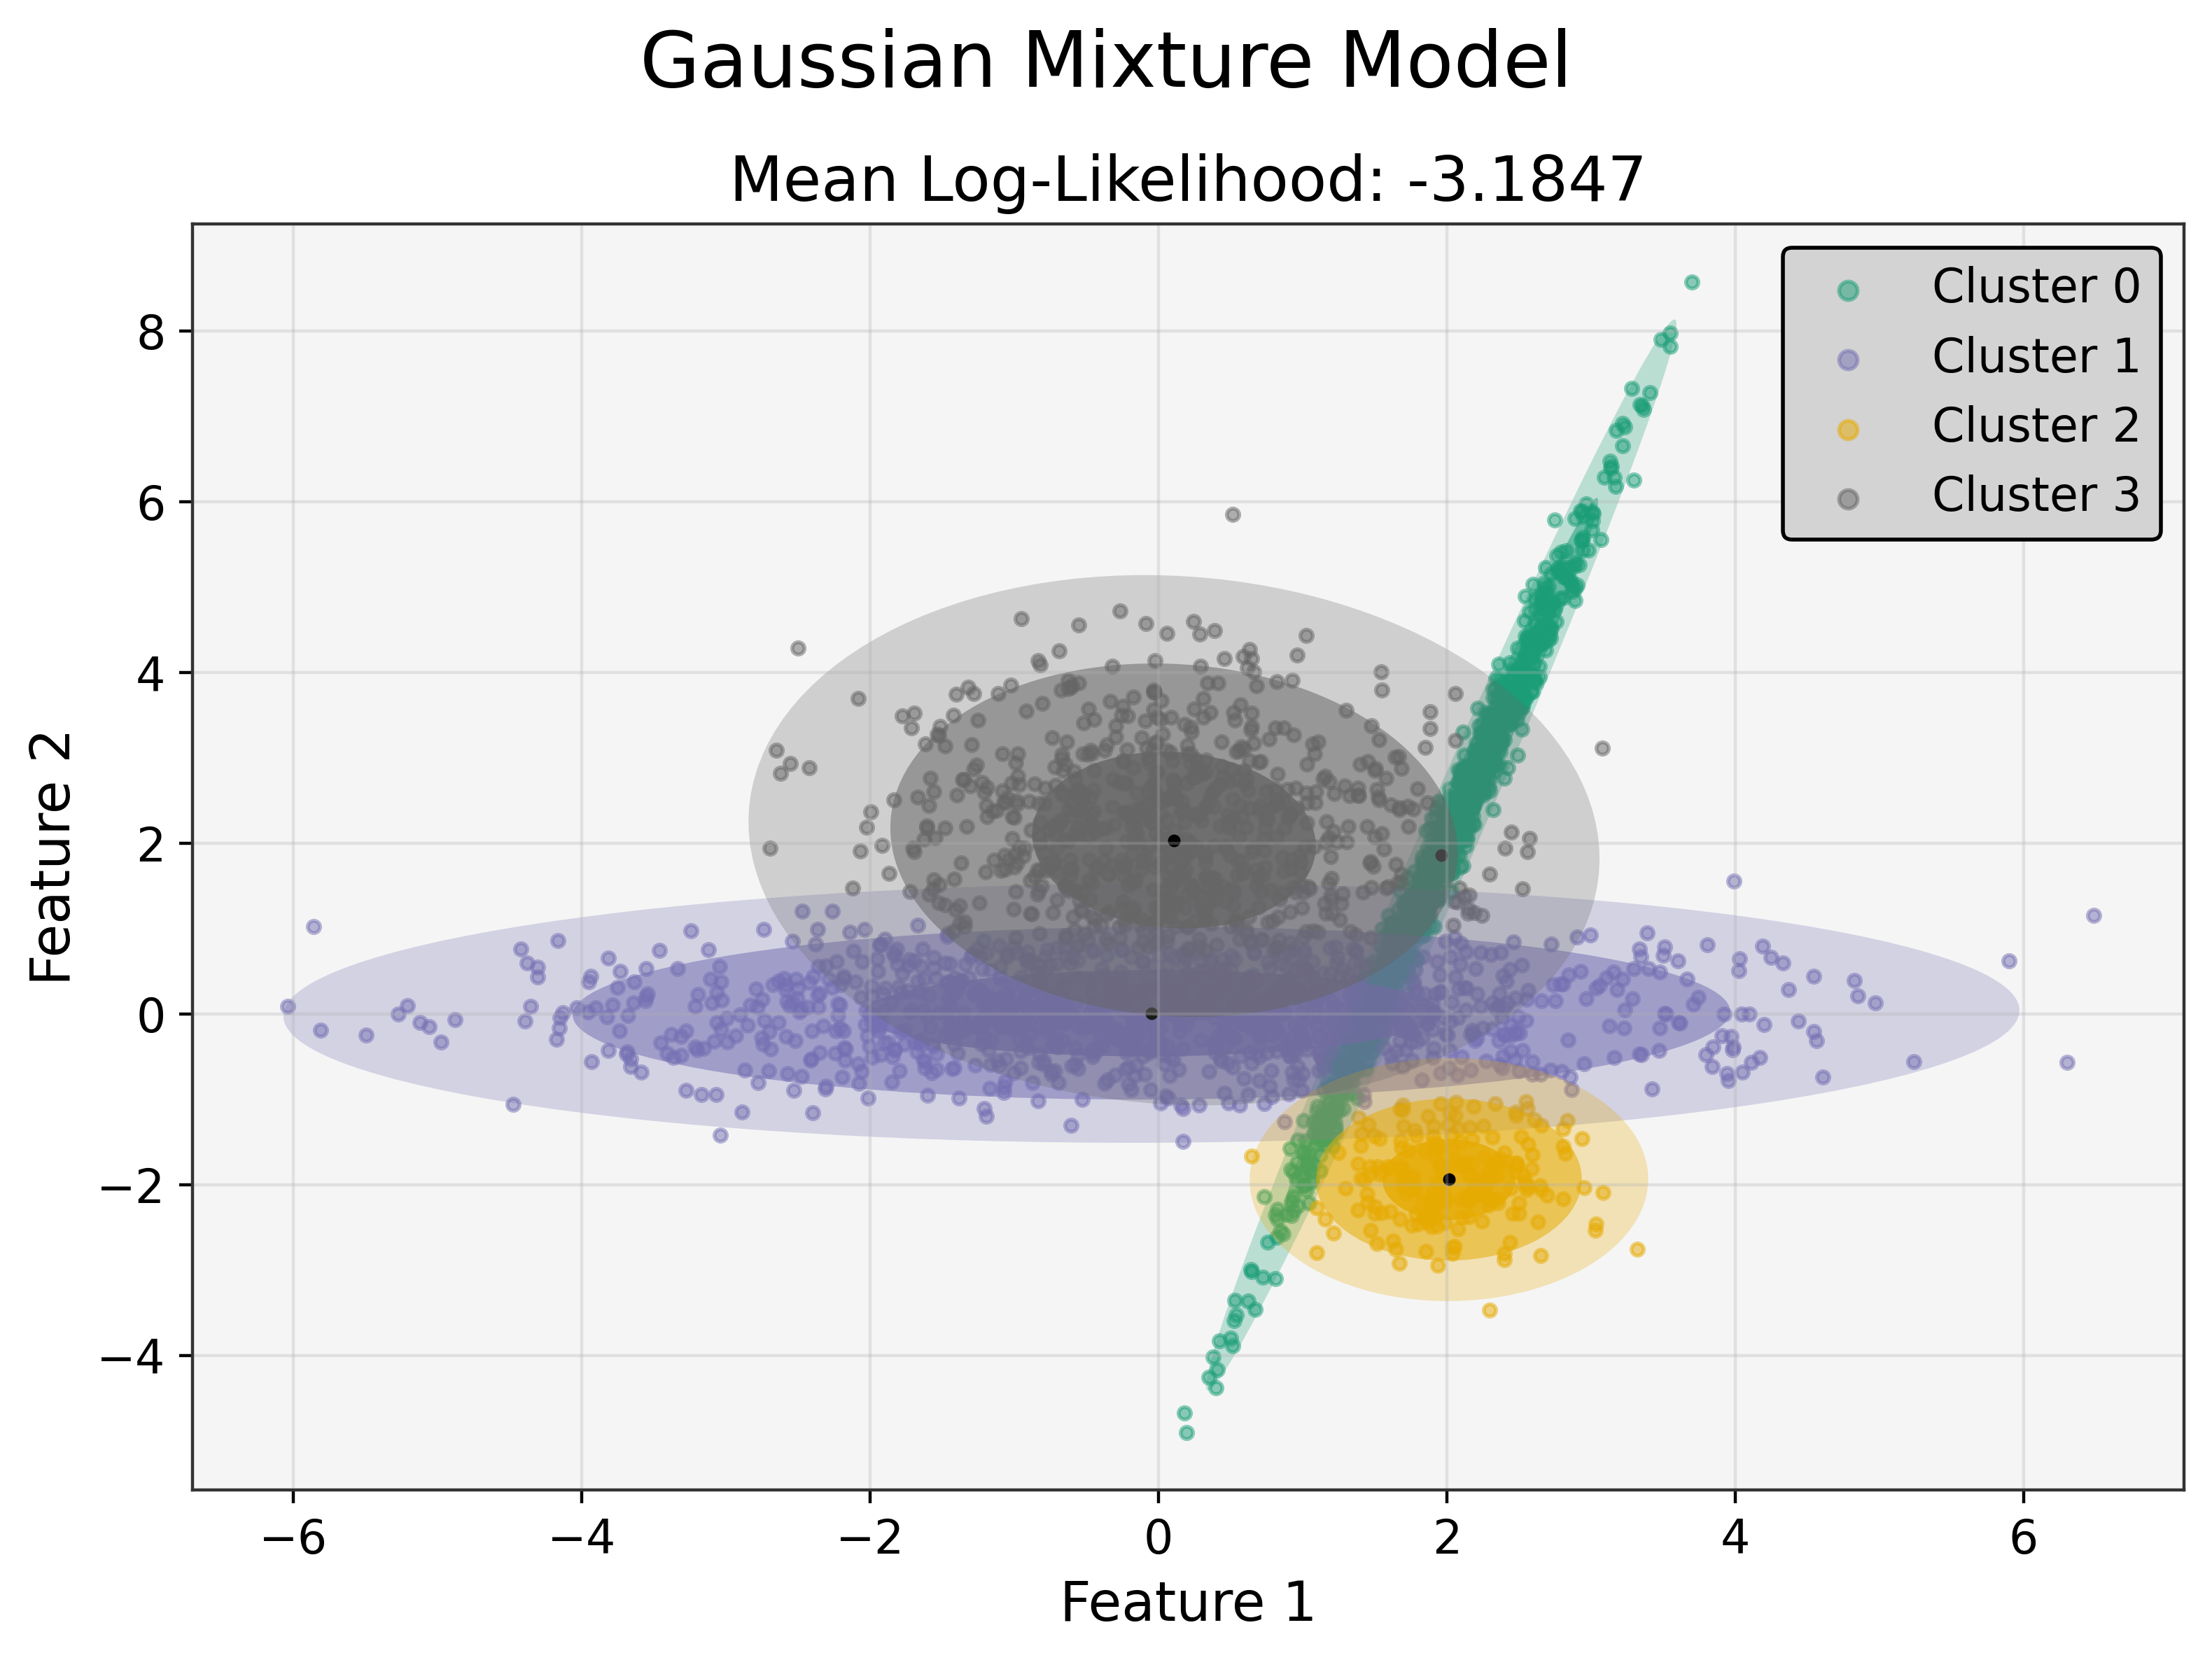

In [5]:
nrows, ncols = 1, 1
figsize = dynamic_figsize(nrows, ncols)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
fig.suptitle("Gaussian Mixture Model")

plot_gmm(X=X, gmm=gmm, title=f'Mean Log-Likelihood: {gmm.score(X_tensor):.4f}', mode='cluster', ax=ax)

plt.tight_layout() 
plt.show()

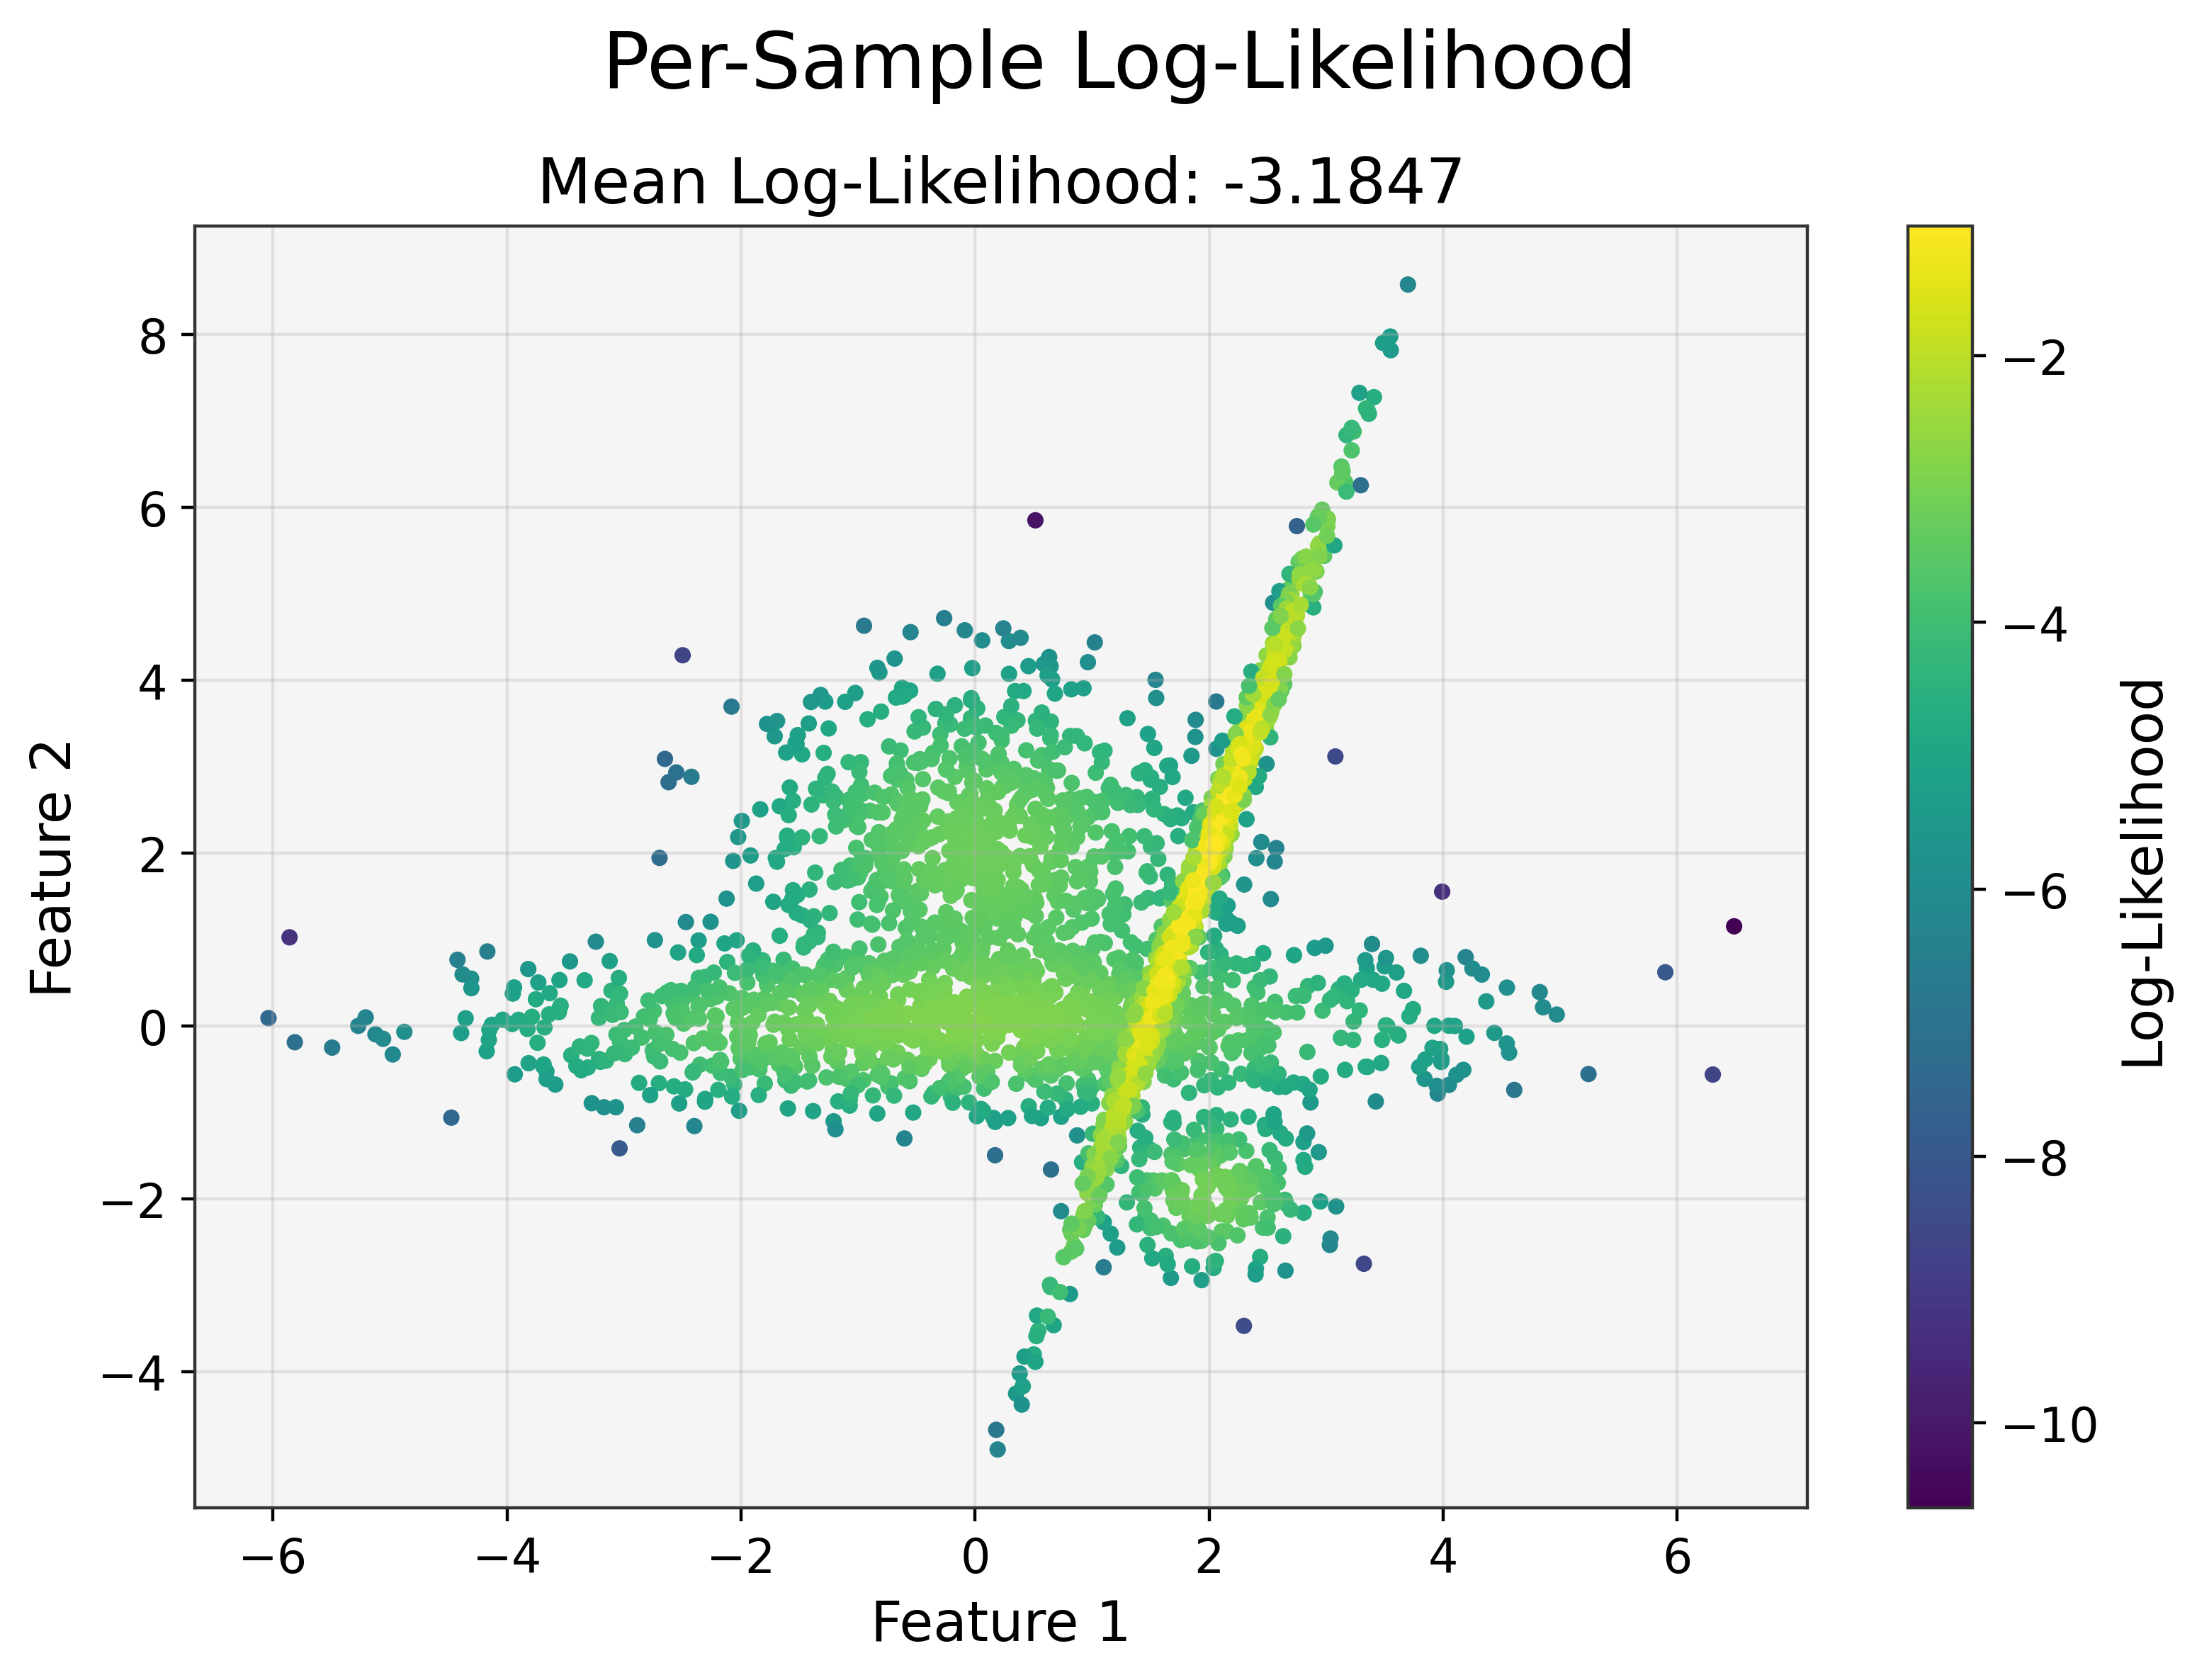

In [6]:
nrows, ncols = 1, 1
figsize = dynamic_figsize(nrows, ncols)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
fig.suptitle("Per-Sample Log-Likelihood")

plot_gmm(X=X, title=f'Mean Log-Likelihood: {gmm.score(X_tensor):.4f}', mode='continuous', color_values=log_probs, cmap_cont='viridis', cbar_label='Log-Likelihood', ax=ax)

plt.tight_layout() 
plt.show()

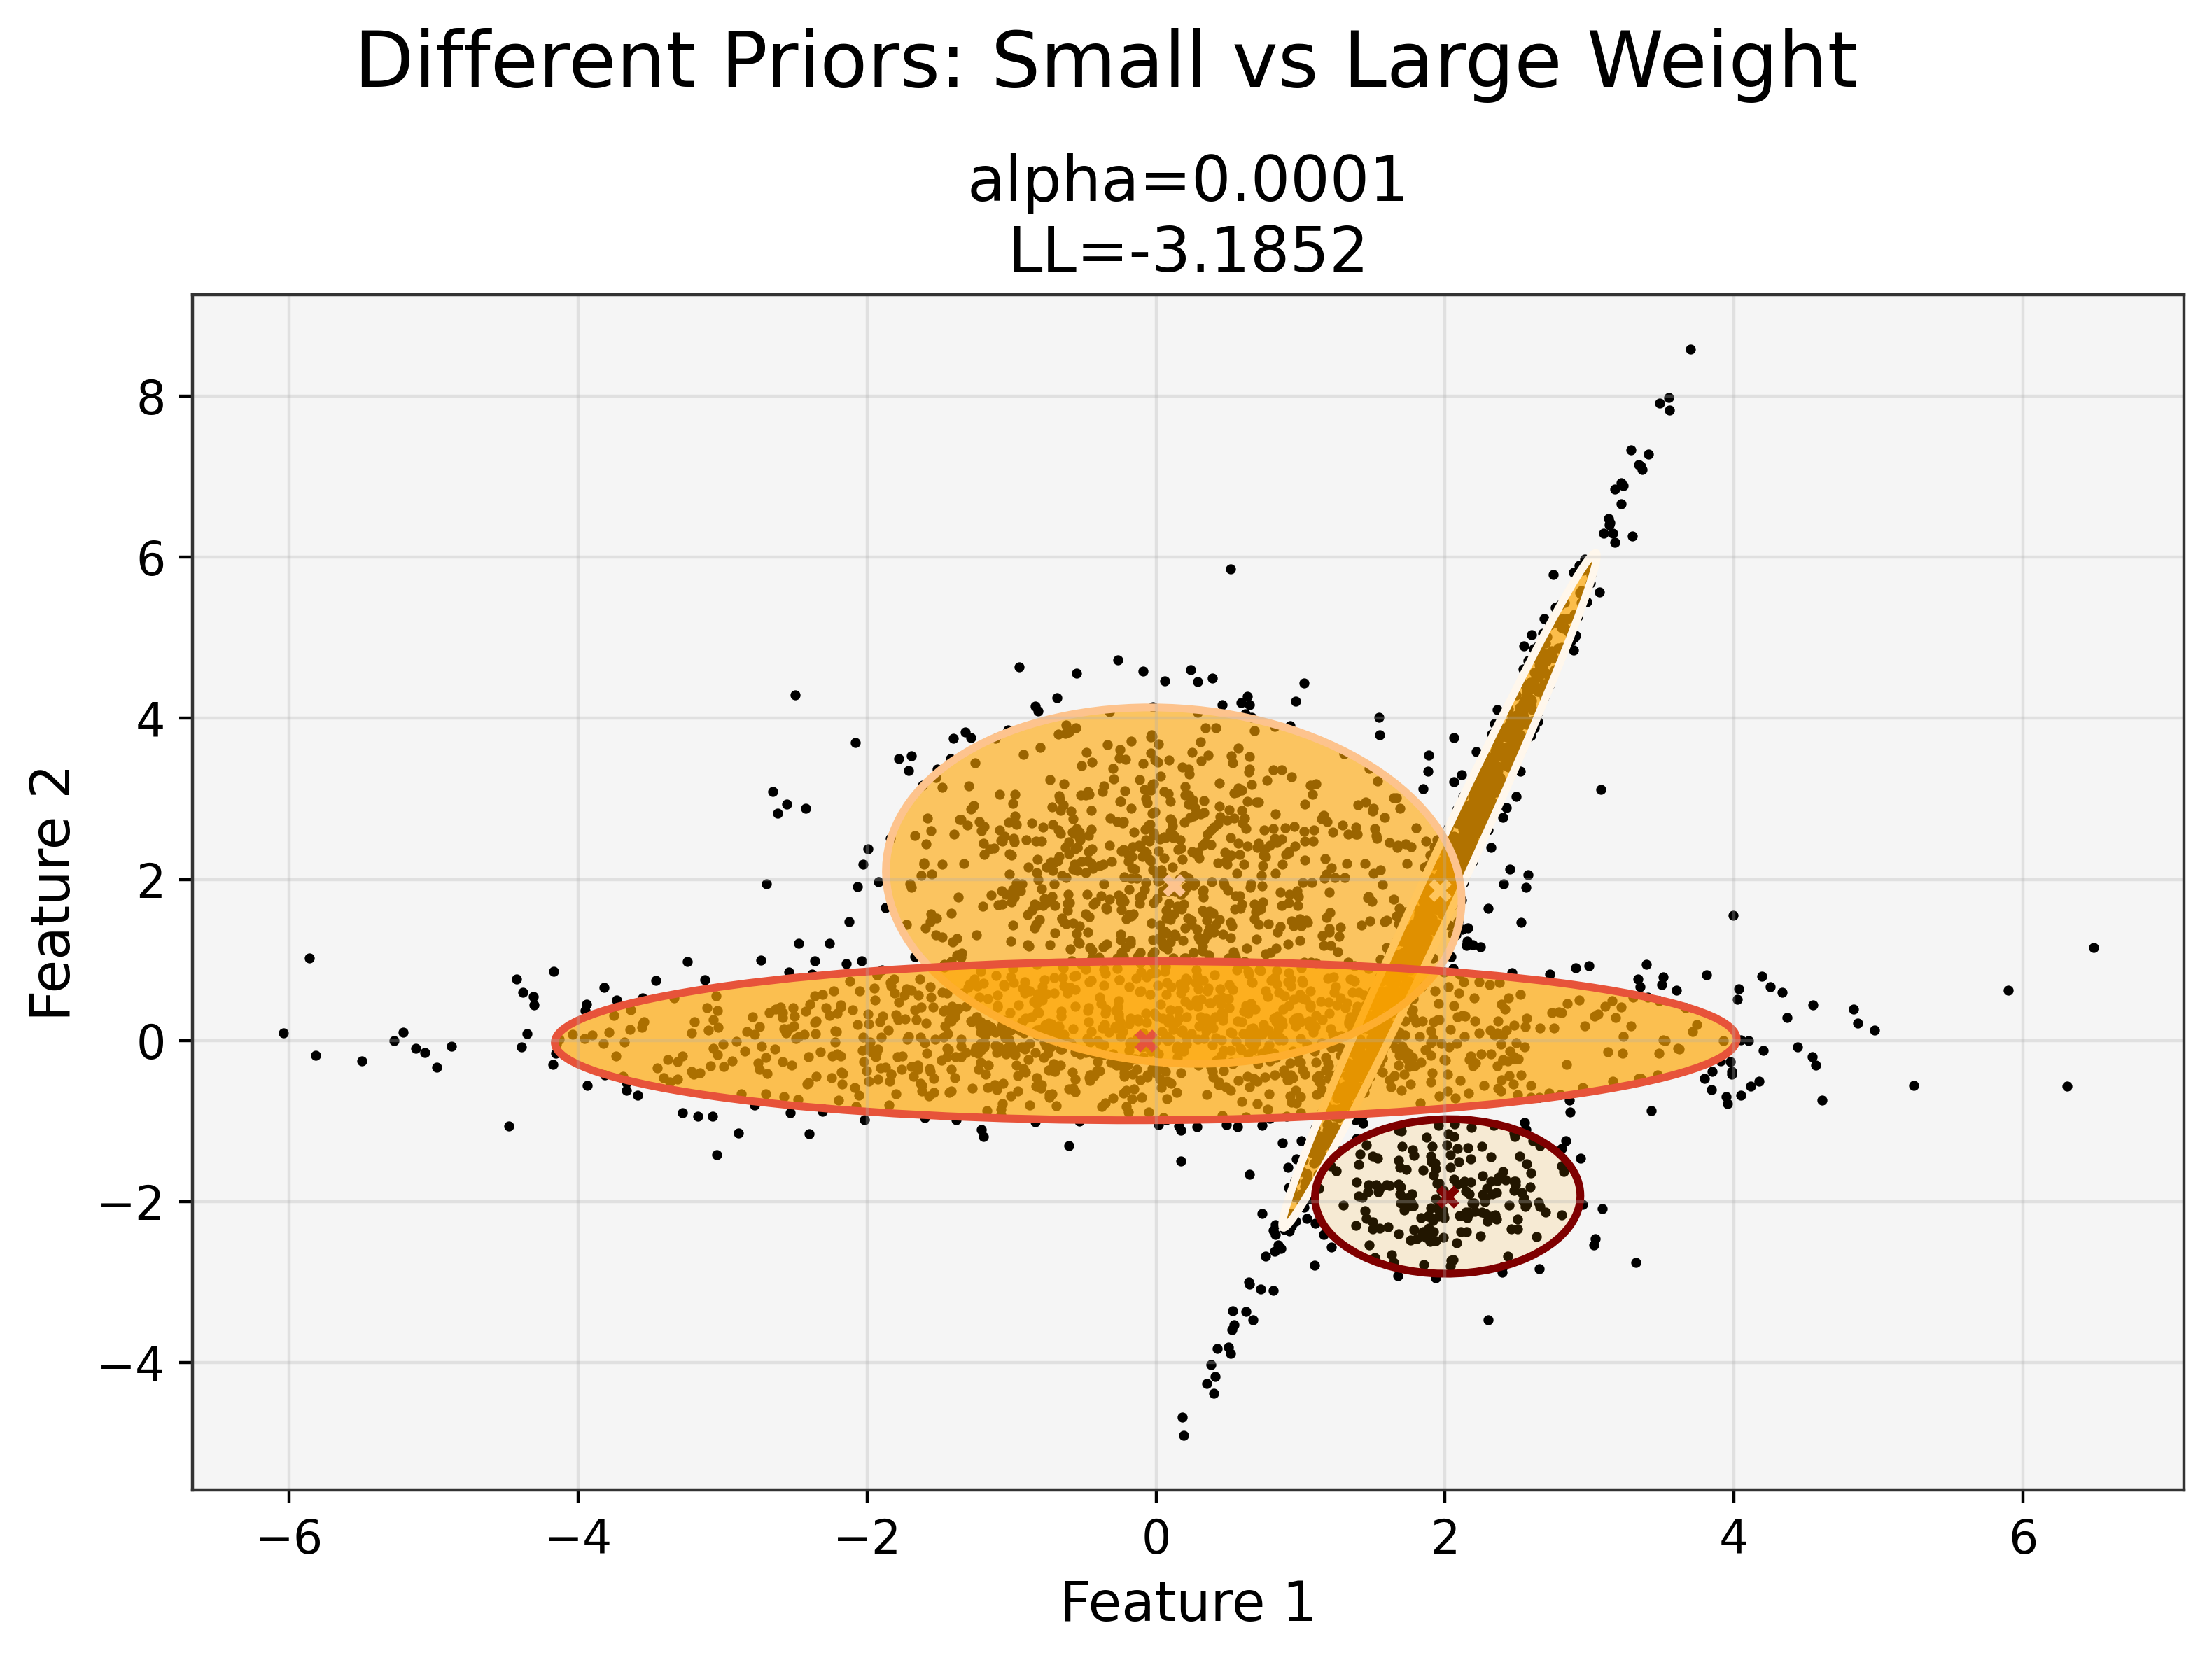

In [7]:
weight = 1e-4
weight = torch.tensor([weight], device=device)

nrows, ncols = 1, 1
figsize = dynamic_figsize(nrows, ncols)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
fig.suptitle("Different Priors: Small vs Large Weight")

gmm_weight_prior = GaussianMixture(
    n_features=n_features,
    n_components=n_components,
    covariance_type='full',
    max_iter=1000,
    device=device,
    weight_concentration_prior=weight,
    random_state=random_state,
    init_params='random'
)
gmm_weight_prior.fit(X_tensor)
plot_gmm(X=X, gmm=gmm_weight_prior, ax=ax,
            title=f"alpha={weight.item():.4f}\nLL={gmm_weight_prior.lower_bound_:.4f}",
            alpha_from_weight=True,
            dashed_outer=True,
            base_alpha=0.7,
            mode='weights')

plt.tight_layout()
plt.show()

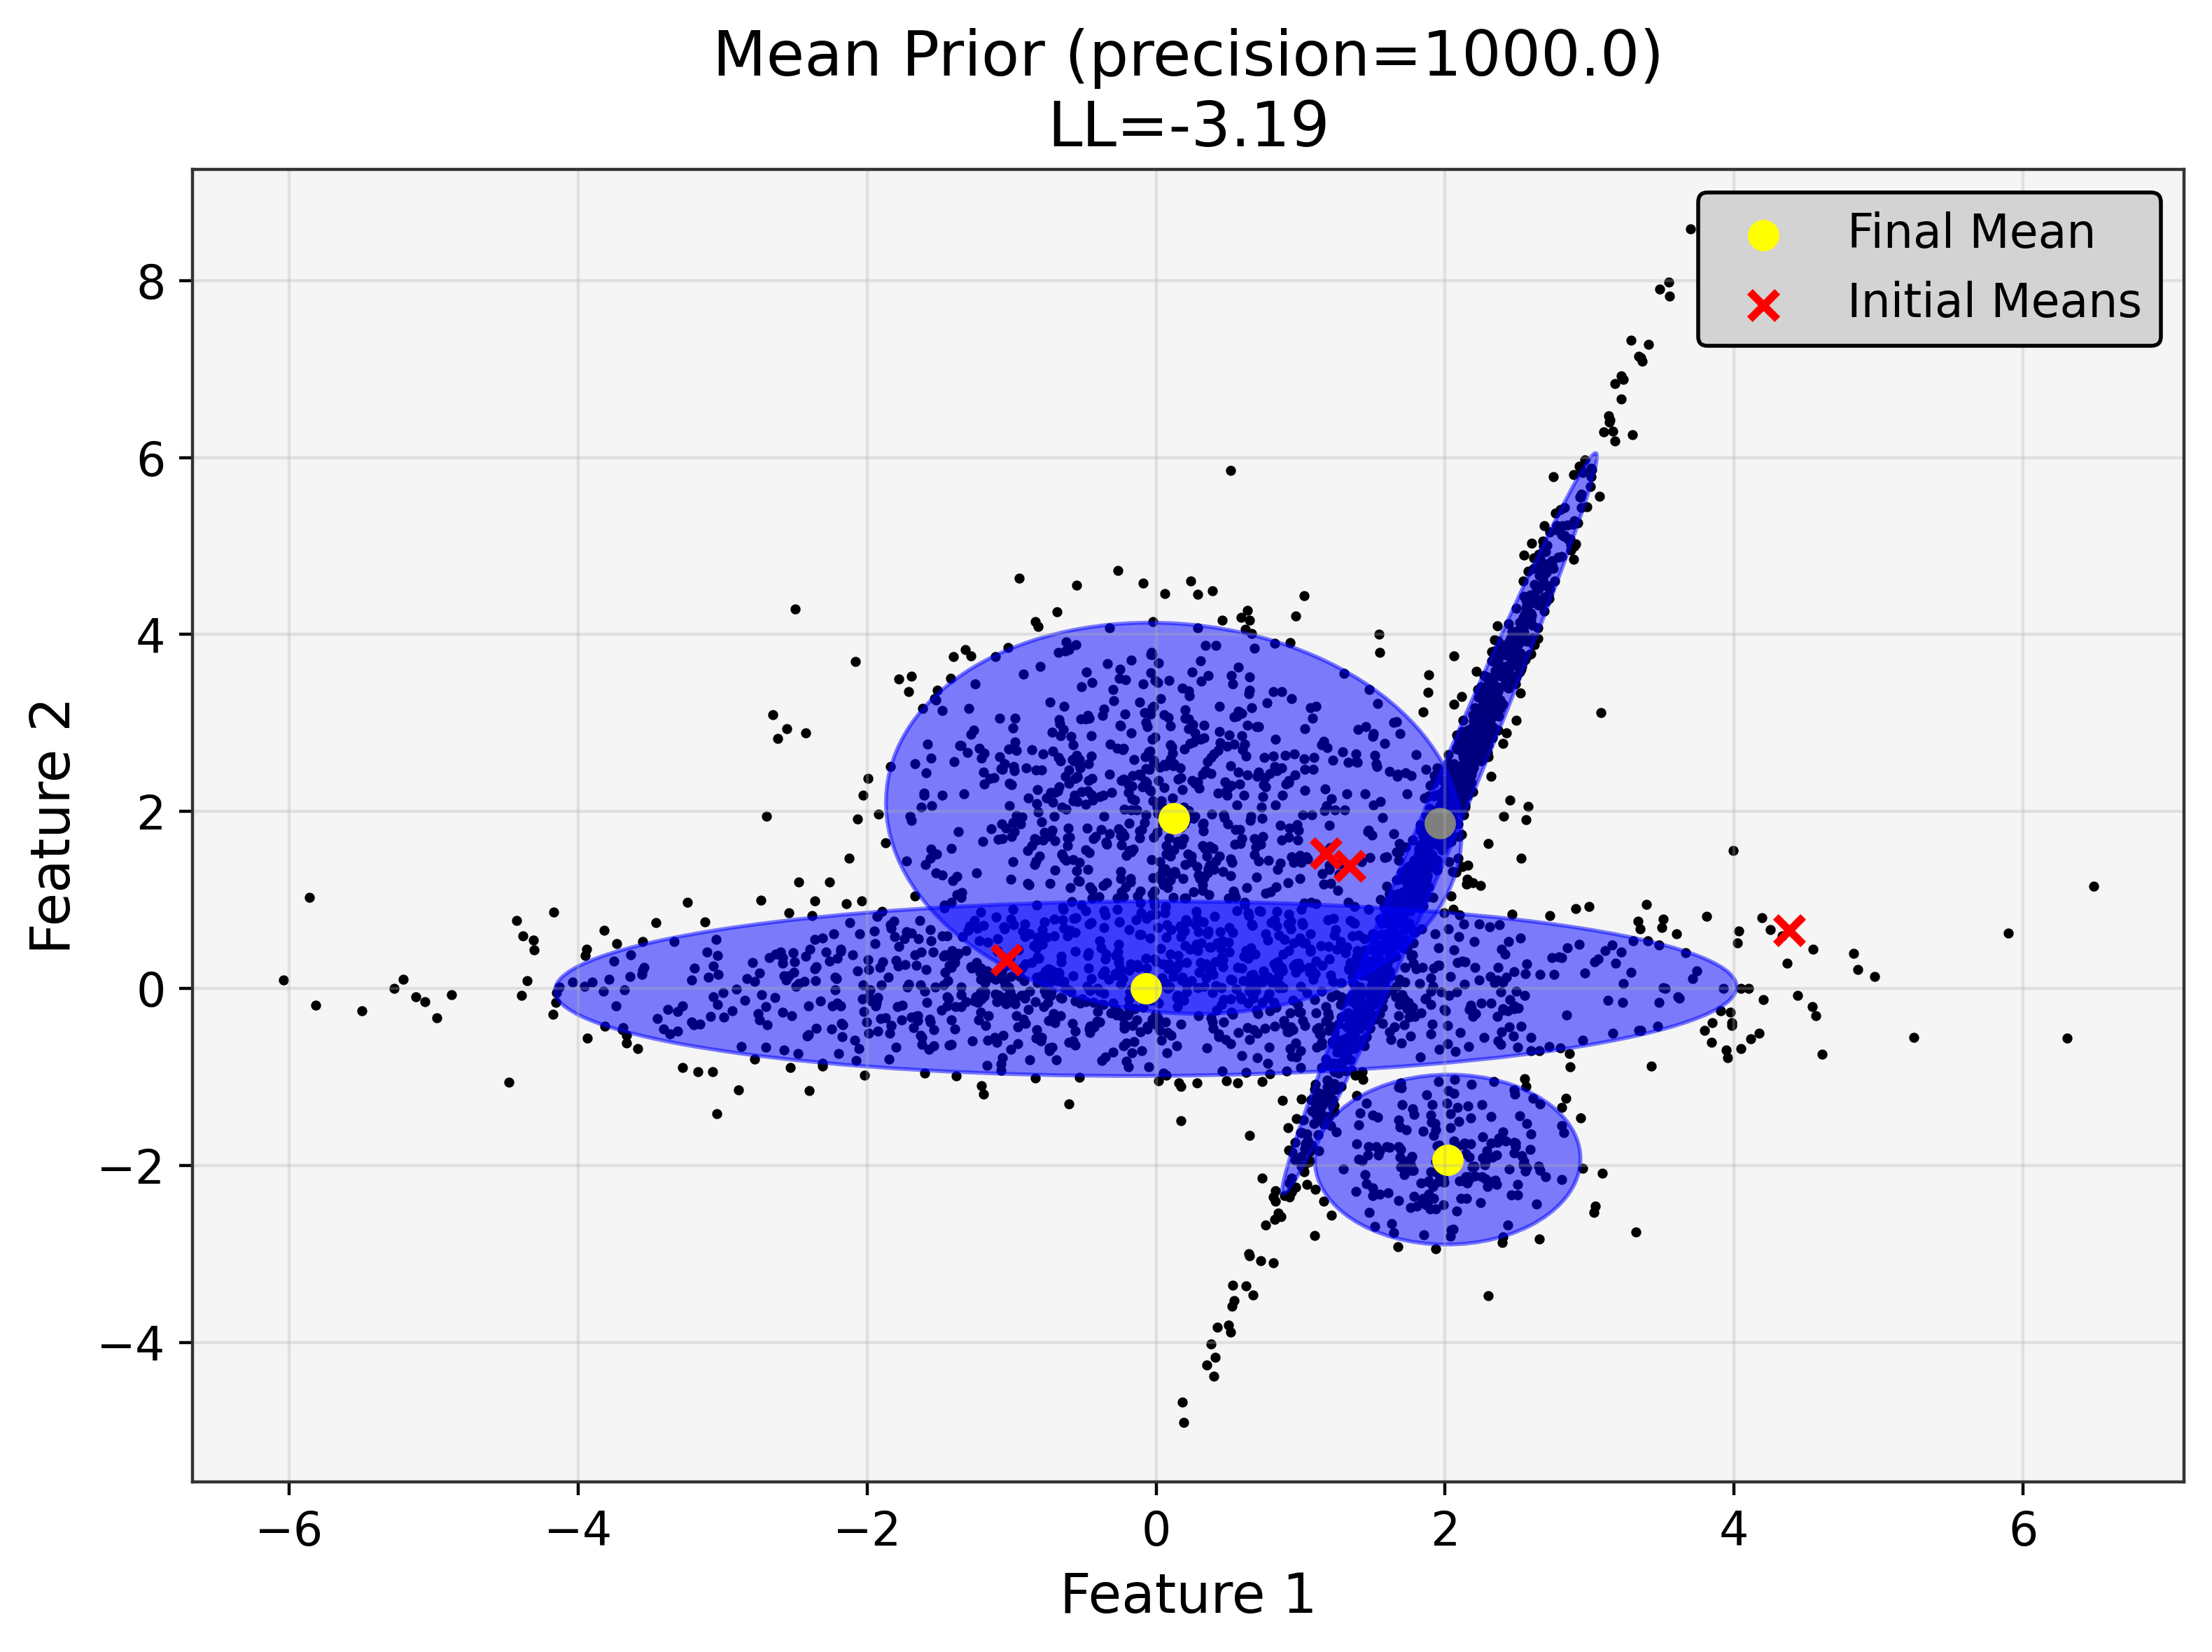

In [9]:
precision = 1e3

# Create the initial means using K-means on the CPU
init_means = GMMInitializer.random(X_tensor.cpu(), k=n_components)
init_means = init_means.clone().to(device)

nrows, ncols = 1, 1
figsize = dynamic_figsize(nrows, ncols)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

gmm_mean_prior = GaussianMixture(
    n_features=n_features,
    n_components=n_components,
    covariance_type='full',
    max_iter=1000,
    device=device,
    means_init=init_means,
    random_state=random_state
)
gmm_mean_prior.fit(X_tensor)

title = f"Mean Prior (precision={precision})\nLL={gmm_mean_prior.lower_bound_:.2f}"
# Plot using mode 'means' with a base alpha of 0.5
plot_gmm(
    X=X,
    gmm=gmm_mean_prior,
    ax=ax,
    title=title,
    base_alpha=0.5,
    dashed_outer=True,
    mode='means',
    init_means=init_means
)
ax.legend()

plt.tight_layout()
plt.show()


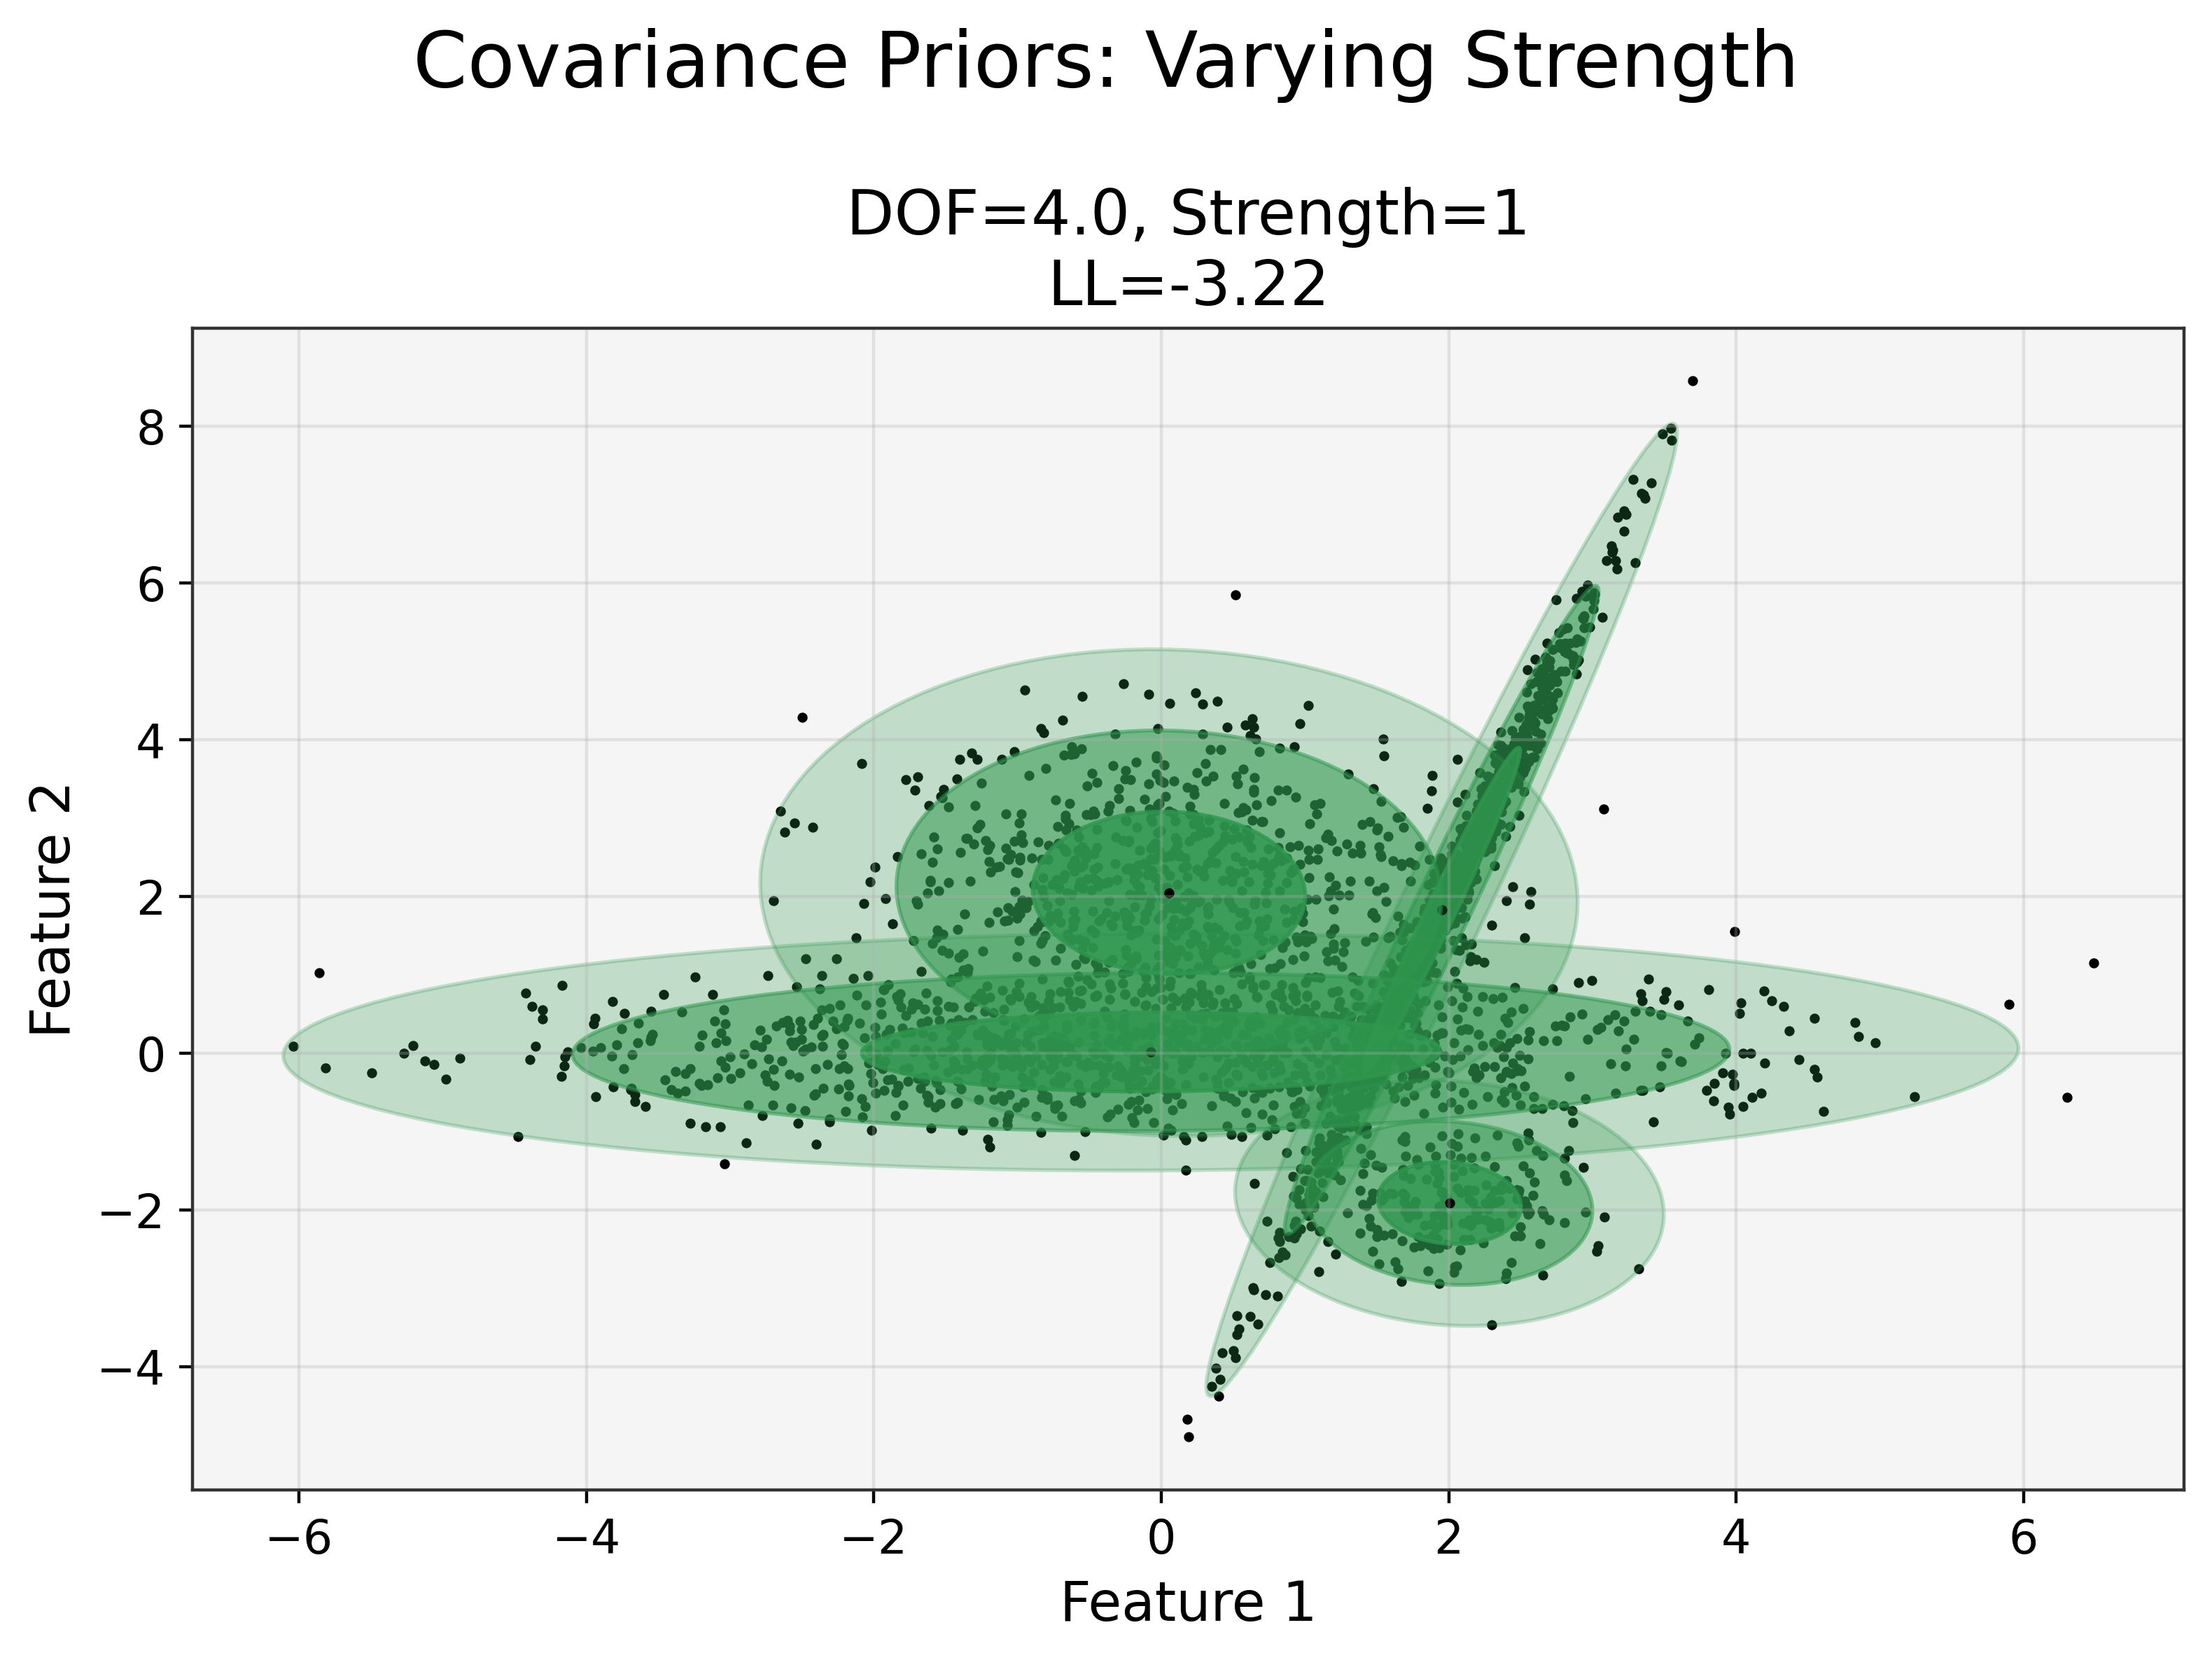

In [ ]:
data_covariance = np.cov(X_tensor.cpu().numpy(), rowvar=False)  # shape (2, 2)
data_covariance = torch.tensor(data_covariance, dtype=torch.float32, device=device)
data_covariance = data_covariance.unsqueeze(0).expand(n_components, -1, -1)

degrees_of_freedom_prior = float(n_features + 2)
prior_strength = 1

nrows, ncols = 1, 1
figsize = dynamic_figsize(nrows, ncols)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
fig.suptitle("Covariance Priors: Varying Strength")


cov_prior = data_covariance * prior_strength

dummy_mean_prior = torch.zeros(n_components, n_features, device=device)
dummy_mean_precision_prior = 1e-10  # effectively no strong push on means

gmm_cov_prior = GaussianMixture(
    n_features=n_features,
    n_components=n_components,
    covariance_type='full',
    max_iter=10000,
    device=device,
    # Covariance prior:
    covariance_prior=cov_prior,  
    degrees_of_freedom_prior=degrees_of_freedom_prior,
    # Provide "dummy" mean priors so code doesn't crash
    mean_prior=dummy_mean_prior,
    mean_precision_prior=dummy_mean_precision_prior
)
gmm_cov_prior.fit(X_tensor)

title = f"DOF={degrees_of_freedom_prior}, Strength={prior_strength}\nLL={gmm_cov_prior.lower_bound_:.2f}"
# Use mode 'covariances' with the sequential colormap (default: Greens) and std_devs [1,2,3]
plot_gmm(
    X=X,
    gmm=gmm_cov_prior,
    ax=ax,
    title=title,
    mode='covariances',
    cmap_seq='Greens',
    std_devs=[1, 2, 3]
)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()
